# Demo Transformer Model para estimar un valor en una serie temporal
Basado en 
 
 https://towardsdatascience.com/the-time-series-transformer-2a521a0efad3
 
 https://medium.com/mlearning-ai/transformer-implementation-for-time-series-forecasting-a9db2db5c820
 
 https://keras.io/examples/timeseries/timeseries_transformer_classification/

1) Cargar librerías:

In [1]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import math

print("Librerías cargadas")

Librerías cargadas


2) Cargar los datos:

In [2]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoML/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [3]:
## selección de los parámetros 

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'CLIMA.csv'  #@param {type:"string"}
#@markdown ### Nombre del atributo a estimar:
atributo_estimar = 'Humedad' #@param {type:"string"}
#@markdown ### Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   80#@param {type:"integer"}

## aplicación de los parámetros elegidos

# define nombre atributo de CLASE para ejemplo IRIS
ClassAttributeName = atributo_estimar

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

print("Configuración definida de ", archivo_datos)


Configuración definida de  CLIMA.csv


In [4]:
#@title Cargar datos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos)
print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())

# genera los datos solo con la clase para entrenar y probar
Yori = np.array(df.pop(ClassAttributeName))
Xori = np.array(df)



> Cabecera: 
   MaxTemp  MinTemp  CantLluvia  VelViento    Humedad   RadSolar
0     28.0   16.851         0.0   4.115179  54.014606  34.023094
1     29.0   15.581         0.0   3.828738  54.534280  33.991928
2     33.0   19.627         0.0   4.481996  50.441004  29.988900
3     35.0   19.131         0.0   4.038467  47.209254  30.184419
4     29.0    8.614         0.0   2.751128  34.174579  27.685916

> Características: 
            MaxTemp       MinTemp    CantLluvia     VelViento       Humedad  \
count  25974.000000  25974.000000  25974.000000  25974.000000  25974.000000   
mean      23.306640     12.267206      2.681185      3.953890     64.749881   
std        7.795314      5.563365      9.276417      1.298974     17.197800   
min        6.000000     -3.734000      0.000000      0.879855     13.768390   
25%       17.000000      8.087250      0.000000      3.021895     52.244933   
50%       23.000000     12.292000      0.000000      3.816113     65.828114   
75%       29.000000   

In [5]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "MinMax Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(Xori[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler": 
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler": 
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler": 
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler": 
    scaler = preprocessing.RobustScaler()
  
  # normaliza los datos de entrada
  Xori = scaler.fit_transform(Xori)
  
  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(Xori[:10])

10 primeros datos de Entrada antes de normalizar: 
[[28.         16.851       0.          4.11517889 34.02309402]
 [29.         15.581       0.          3.82873837 33.9919281 ]
 [33.         19.627       0.          4.48199627 29.98889964]
 [35.         19.131       0.          4.03846654 30.18441906]
 [29.          8.614       0.          2.75112845 27.6859161 ]
 [30.          7.584       0.          2.36142894 27.75296214]
 [24.         16.603       5.          2.97655439 10.66077828]
 [25.         15.895       2.          2.5238168  11.21641362]
 [17.          7.029       0.          4.80350817 14.97065976]
 [17.          6.465       0.          4.06358332 15.50559312]]


10 primeros datos de Entrada después de normalizar: 
[[0.55       0.60294075 0.         0.23409934 0.96336397]
 [0.575      0.56574207 0.         0.21337327 0.96248151]
 [0.675      0.68425061 0.         0.26064126 0.84913575]
 [0.725      0.66972262 0.         0.22854864 0.85467188]
 [0.575      0.36167658 0.     

In [6]:
#@title Generar serie como secuencia de datos

cantidad_intervalos_secuencia = 5 #@param {type:"integer"}

usar_atributos_secuencia = "Todos" #@param ["Solo atributo a Estimar", "Solo atributos de Entrada", "Todos"]

if cantidad_intervalos_secuencia < 1:
  cantidad_intervalos_secuencia = 1

# funciones auxilliares
def split_sequence(datosX, datosY, n_steps, atr_seq):
  x, y = [], []
  if len(datosX) != len(datosY):
    print("No coincide el largo de los datos X e Y!!!")
    return None, None
  for i in range(len(datosY)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(datosY)-1:
      break
    # gather input and output parts of the pattern
    if atr_seq == "Y":
      # sólo atributo a estimar (anteriores)
      seq_x = datosY[i:end_ix]
      seq_y = datosY[end_ix]   
    elif atr_seq == "X":
      # sólo atributos de entrada (anteriores y actuales)
      seq_x = datosX[i:end_ix]
      seq_y = datosY[end_ix-1]   
    else:
      # atributos de entrada y a estimar (anteriores)
      seq_xa = datosX[i:end_ix]
      seq_xb = datosY[i:end_ix] 
      seq_y = datosY[end_ix]  
      seq_x = []
      for xa, xb in zip(seq_xa, seq_xb):        
        xa = list(xa)
        xa.append(xb)
        seq_x.append(xa)

    x.append( seq_x )
    y.append( seq_y )
  return np.array(x), np.array(y)

# muestra los primeros "cant" datos
def mostrarEjemplos(X, Y, cant=5):
  for i in range(min(len(X), cant)):
    print(X[i], Y[i])
  print("\n")

print("\n> Antes de generar serie: ")
mostrarEjemplos(Xori, Yori)

# genera secuencias
print("> Generando series con ", cantidad_intervalos_secuencia ," intervalos ")
if (Xori.shape[1] == 0) or usar_atributos_secuencia == "Solo atributo a Estimar": 
  atrSeq = "Y"
  cant_atributos_entrada = 1
elif usar_atributos_secuencia == "Solo atributos de Entrada":
  atrSeq = "X"
  cant_atributos_entrada = Xori.shape[1]
else: # "Todos"
  atrSeq = "XY"
  cant_atributos_entrada = Xori.shape[1] + 1
X, Y = split_sequence(Xori, Yori, cantidad_intervalos_secuencia, atrSeq)

print("\n> Después de generar serie: ")
mostrarEjemplos(X, Y)



> Antes de generar serie: 
[0.55       0.60294075 0.         0.23409934 0.96336397] 54.01460647
[0.575      0.56574207 0.         0.21337327 0.96248151] 54.53428037
[0.675      0.68425061 0.         0.26064126 0.84913575] 50.44100419
[0.725      0.66972262 0.         0.22854864 0.85467188] 47.20925441
[0.575      0.36167658 0.         0.13540031 0.78392677] 34.17457853


> Generando series con  5  intervalos 

> Después de generar serie: 
[[ 0.55        0.60294075  0.          0.23409934  0.96336397 54.01460647]
 [ 0.575       0.56574207  0.          0.21337327  0.96248151 54.53428037]
 [ 0.675       0.68425061  0.          0.26064126  0.84913575 50.44100419]
 [ 0.725       0.66972262  0.          0.22854864  0.85467188 47.20925441]
 [ 0.575       0.36167658  0.          0.13540031  0.78392677 34.17457853]] 31.15338649
[[ 0.575       0.56574207  0.          0.21337327  0.96248151 54.53428037]
 [ 0.675       0.68425061  0.          0.26064126  0.84913575 50.44100419]
 [ 0.725       0.6

In [7]:
#@title Preparar datos 


# reshape de [cant ejemplos, datos entrada] into [cant ejemplos, intervalos, datos entrada]
X =  X.reshape((X.shape[0], cantidad_intervalos_secuencia, cant_atributos_entrada))

# separa al azar usando muestreo estratificado con proporción indicada
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain))


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, intervalos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, intervalos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))



> Para Entrenamiento: 
 - x_train (cant ejemplos, intervalos, datos entrada):  (20775, 5, 6)
 - y_train (cant):  20775

 Para Prueba: 
 - x_test (cant ejemplos, intervalos, datos entrada):  (5194, 5, 6)
 - y_test (cant):  5194


3) Establecer el modelo para el Transformer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 6)]       0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 5, 6)        12          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 5, 6)        27654       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

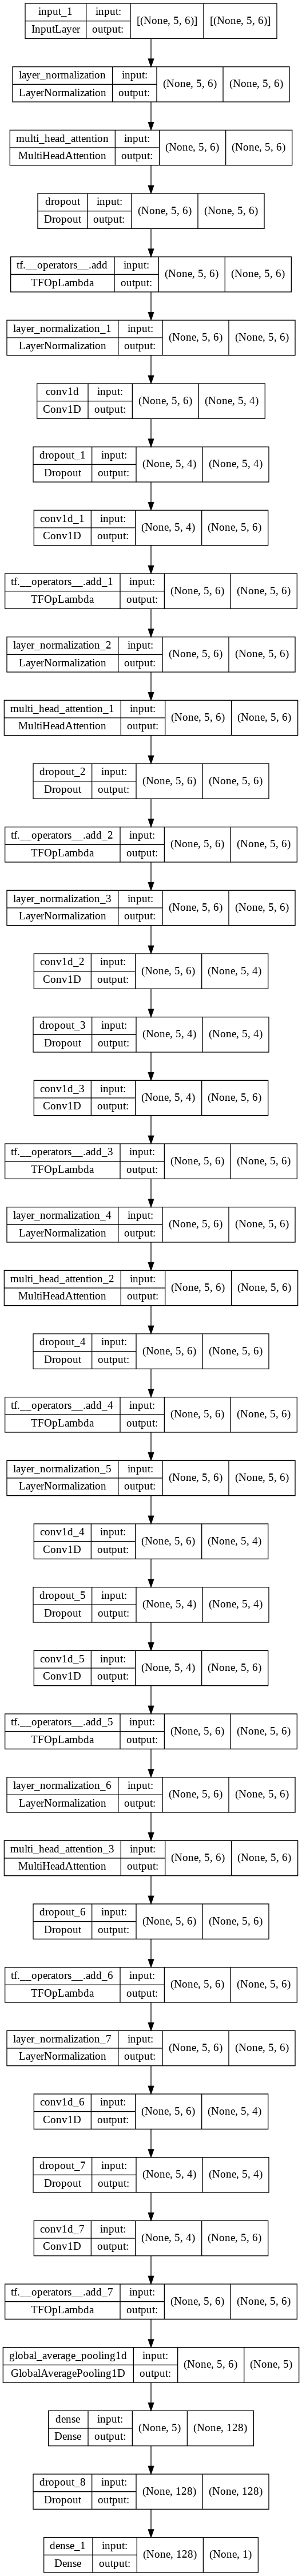

In [8]:
#@title Establecer modelo

cant_bloques_transformer = 4 #@param {type: "integer"}
cant_neuronas_mlp =  128#@param {type: "integer"}

opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "FTRL"]
opt_learning_rate = 0.004 #@param {type: "number"}

if cant_bloques_transformer < 1:
  cant_bloques_transformer = 4

if cant_neuronas_mlp < 1:
  cant_neuronas_mlp = 128

# funciones auxiliares para crear el modelo
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    # se genera una capa lineal con una salida numérica
    outputs = layers.Dense(1, activation=None)(x)
    return keras.Model(inputs, outputs)



input_shape = x_train.shape[1:]

# crea el modelo del Transformer
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=cant_bloques_transformer,
    mlp_units=[cant_neuronas_mlp],
    mlp_dropout=0.4,
    dropout=0.25,
)

# compila el modelo

if opt_tipo == "Gradiente Decreciente":
  opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
elif opt_tipo == "Adam":
  opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
elif opt_tipo == "Adadelta":
  opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
elif opt_tipo == "Adagrad":
  opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
elif opt_tipo == "Adamax":
  opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
elif opt_tipo == "Nadam":
  opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
elif opt_tipo == "FTRL":
  opt = keras.optimizers.Ftrl(learning_rate=opt_learning_rate)
else:
  opt = keras.optimizers.Adam(learning_rate=1e-4)

# utiliza un loss de valor numérico
model.compile(optimizer=opt, loss='mse')

model.summary()

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


4) Entrenar el modelo de la RNA:

In [13]:
#@title Entrenar

cant_epocas_entrenamiento =   250#@param {type:"integer"}

# cantidad de épocas del entrenamiento
cantEpocas = (1 if cant_epocas_entrenamiento<1 else cant_epocas_entrenamiento)

# separa al azar usando muestreo al azar del 10%
# para tomar algunos como datos de validación
x_t, x_v, y_t, y_v = train_test_split(x_train, 
                                       y_train, 
                                       test_size=0.1)


print("\n> De los ", len(x_train), "ejemplos de entrenamiento: ")
print("            se usan ", len(x_t), "ejemplos para entrenar ")
print("            y ", len(x_v), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

activar_corte_por_estabilidad_error_val = False

if activar_corte_por_estabilidad_error_val:
  # se agrega un callBack para que corte 
  # si el error de validación no sigue bajando
  # y devuelva los mejores pesos obtenidos
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0.01,
      patience=25,
      verbose=0,
      mode='min',
      baseline=None,
      restore_best_weights=True
  )
  callbacksEntr = [early_stopping_monitor]
else:
  early_stopping_monitor = None
  callbacksEntr = []

# lleva a cabo el entrenamiento
history = model.fit(x_t, y_t,
          epochs = cantEpocas, 
          validation_data=(x_v, y_v,),
          callbacks=callbacksEntr ) 

print("\n>Entrenamiento Finalizado.")



> De los  20775 ejemplos de entrenamiento: 
            se usan  18697 ejemplos para entrenar 
            y  2078 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/250
585/585 [==============================] - 12s 21ms/step - loss: 137.9821 - val_loss: 139.3615
Epoch 2/250
585/585 [==============================] - 12s 20ms/step - loss: 138.9938 - val_loss: 136.3086
Epoch 3/250
585/585 [==============================] - 12s 20ms/step - loss: 137.9882 - val_loss: 142.3975
Epoch 4/250
585/585 [==============================] - 12s 20ms/step - loss: 138.4219 - val_loss: 139.7812
Epoch 5/250
585/585 [==============================] - 12s 20ms/step - loss: 138.0062 - val_loss: 138.9641
Epoch 6/250
585/585 [==============================] - 12s 20ms/step - loss: 138.3429 - val_loss: 137.3535
Epoch 7/250
585/585 [==============================] - 12s 20ms/step - loss: 138.0760 - val_loss: 139.0476
Epoch 8/250
585/585 [==============================] - 12s 20ms/step - loss: 138.7

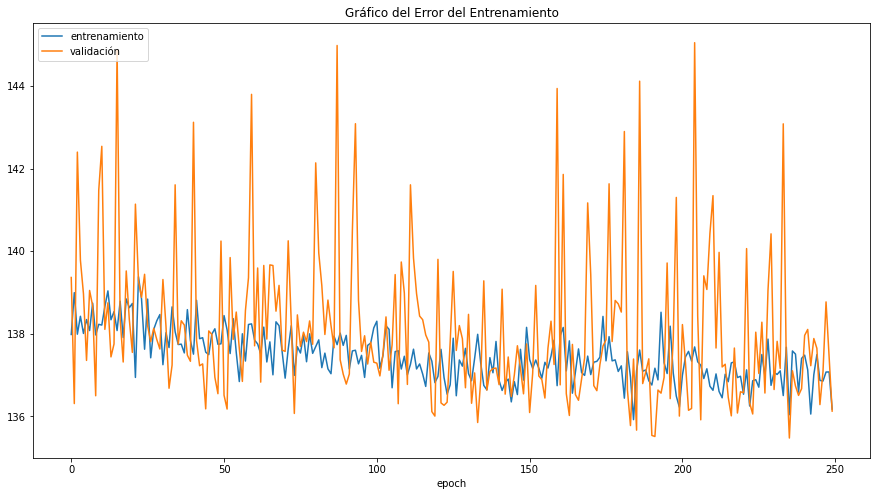

In [14]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()


*** Resultados con datos de Entrenamiento: 


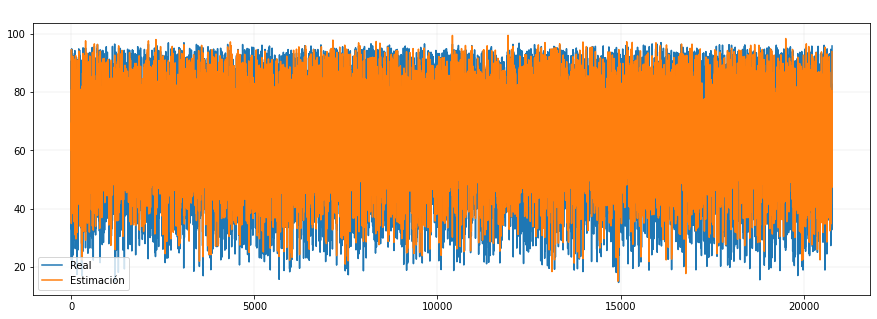




 Error Absoluto: 
            Mínimo: 0.00019 
            Promedio: 7.74188 ± 8.34821
            Máximo: 54.65052 


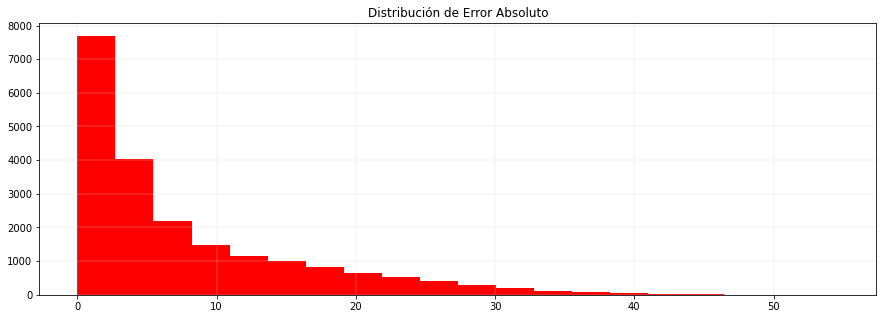


 Error Relativo: 
            Mínimo: 0.00% 
            Promedio: 14.18 ± 20.37
            Máximo: 292.43% 


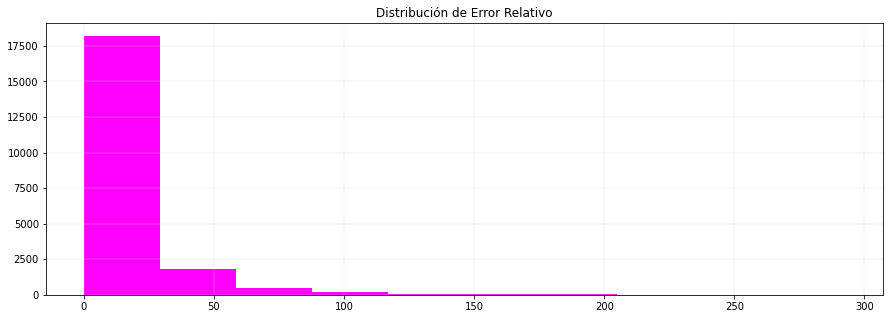

In [15]:
#@title Probar red entrenada con datos de entrenamiento

mostrar_detalle_entrenamiento = False #@param {type:"boolean"}

# función auxiliar para el cálculo de error
def calcErrores(pred, real, mostrarDetalle=False):
  arAbs = []
  arRel = []
  
  if mostrarDetalle:
    print("\n")
    print("\t Real \t\t\t Estimado \t\t Error Absoluto \t Error Relativo")
  
  for pV, r in zip(pred, real):
    # toma el valor estimado/predecido
    p = pV[0]
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)
    
      if mostrarDetalle:
        print("\t{:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f} \t\t {:>8.2f}%".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5)) 
 #   ax = fig.add_axes( [0, 0, 0.8, 0.8] )
 #   ax.boxplot( [arAbs, arRel] )
 #   ax.set_xticklabels( ["Error Absoluto", "Error Relativo"] )
#    plt.legend(["Error Absoluto", "Error Relativo"], loc='best')
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, detalle=False):

    # procesa las imágenes de prueba con el modelo 
    estimVals = model.predict(x)

    # genera gráfico de la serie
    fig = plt.figure(figsize=(15,5)) 
    plt.plot(y)
    plt.plot(estimVals)
    plt.legend(["Real", "Estimación"])
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title(" ")
    plt.show()

    # llama a la función
    arAbs, arRel = calcErrores(estimVals, y, detalle)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.5f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.5f} ± {:.5f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.5f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")
    
    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, mostrar_detalle_entrenamiento)


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:



*** Resultados con datos de Prueba: 


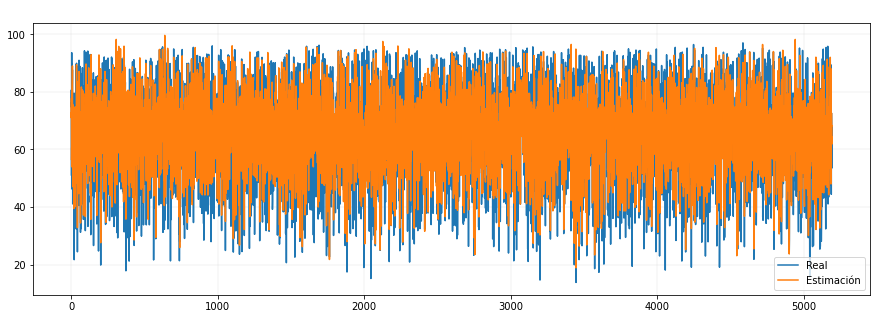




 Error Absoluto: 
            Mínimo: 0.00011 
            Promedio: 7.69752 ± 8.42255
            Máximo: 51.75968 


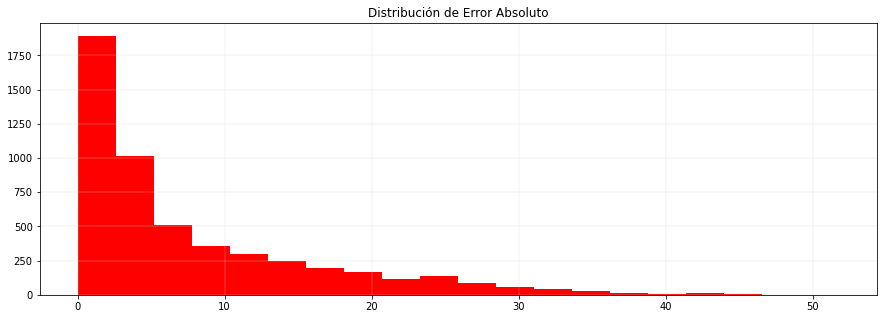


 Error Relativo: 
            Mínimo: 0.00% 
            Promedio: 14.33 ± 21.76
            Máximo: 277.99% 


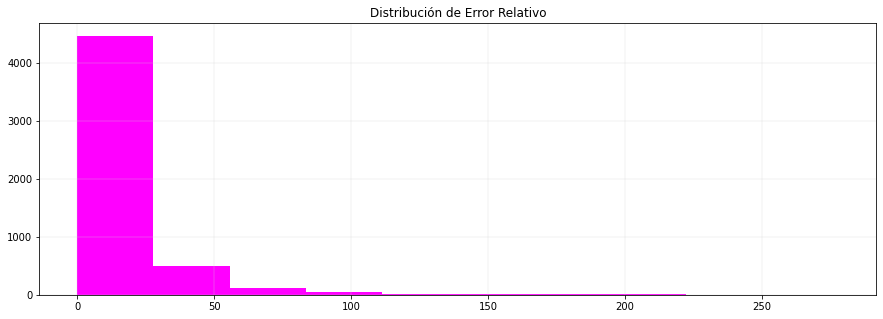

In [16]:
 #@title Probar red entrenada con datos de prueba
 # evalua al modelo entrenado

 mostrar_detalle_prueba = False #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, mostrar_detalle_prueba)